
# Глобальный анализ рынка авокадо: прогностические инсайты от наивных до продвинутых моделей прогнозирования

В последние годы авокадо превратилось в один из самых популярных продуктов в мире, благодаря своим питательным качествам и универсальности в кулинарии. Однако за этой популярностью скрывается сложная сеть глобальных рыночных тенденций, которые сильно влияют на цены. В этом проекте мы исследуем данные по ценам на авокадо из различных стран с целью прогнозирования их стоимости.

Цель - создать надежную модель прогнозирования, которая поможет производителям, розничным торговцам и потребителям лучше понять рыночные условия и принимать обоснованные решения.

Проект охватывает различные аспекты анализа данных, включая сбор и предварительную обработку данных, исследовательский анализ, моделирование и оценку прогнозов. Мы начнем с изучения общих тенденций в данных, затем перейдем к более детальному анализу отдельных стран, и, наконец, разработаем прогностические модели, которые помогут нам предсказать будущие цены на авокадо.

In [ ]:
!pip3 install sktime

In [ ]:
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns
%matplotlib inline

<ipython-input-2-8c07229a07c3>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Данные

Датасет взяты [с соревнавания на kaggle.](https://www.kaggle.com/neuromusic/avocado-prices) В табличке ниже представлены месячные данные по розничной торговле авокадо:

* `Date` - дата наблюдения
* `AveragePrice` - средняя цена одного авокадо
* `Type` - обычный или органический
* `Year` - год
* `Region` - город или регион наблюдения

В оригинальной версии есть еще колонки, но они не будут меня интересовать.

In [ ]:
dff = pd.read_csv('avocado_small.tsv', sep='\t', parse_dates=['Date']).set_index('Date')

# Периодичность данных - месячная
dff.index = dff.index.to_period("M")

# будем смотреть только на тип organic
dff = dff[dff.Type == 'organic']
print(dff.shape)
dff.head()

(2105, 4)


,AveragePrice,Region,Year,Type
Date,,,,
2015-12,1.84,Albany,2015,organic
2015-11,1.88,Albany,2015,organic
2015-10,1.98,Albany,2015,organic
2015-09,1.86,Albany,2015,organic
2015-08,2.00,Albany,2015,organic


Рассмотрим, как менялась цена на авокадо в различных городах на протяжении разных лет

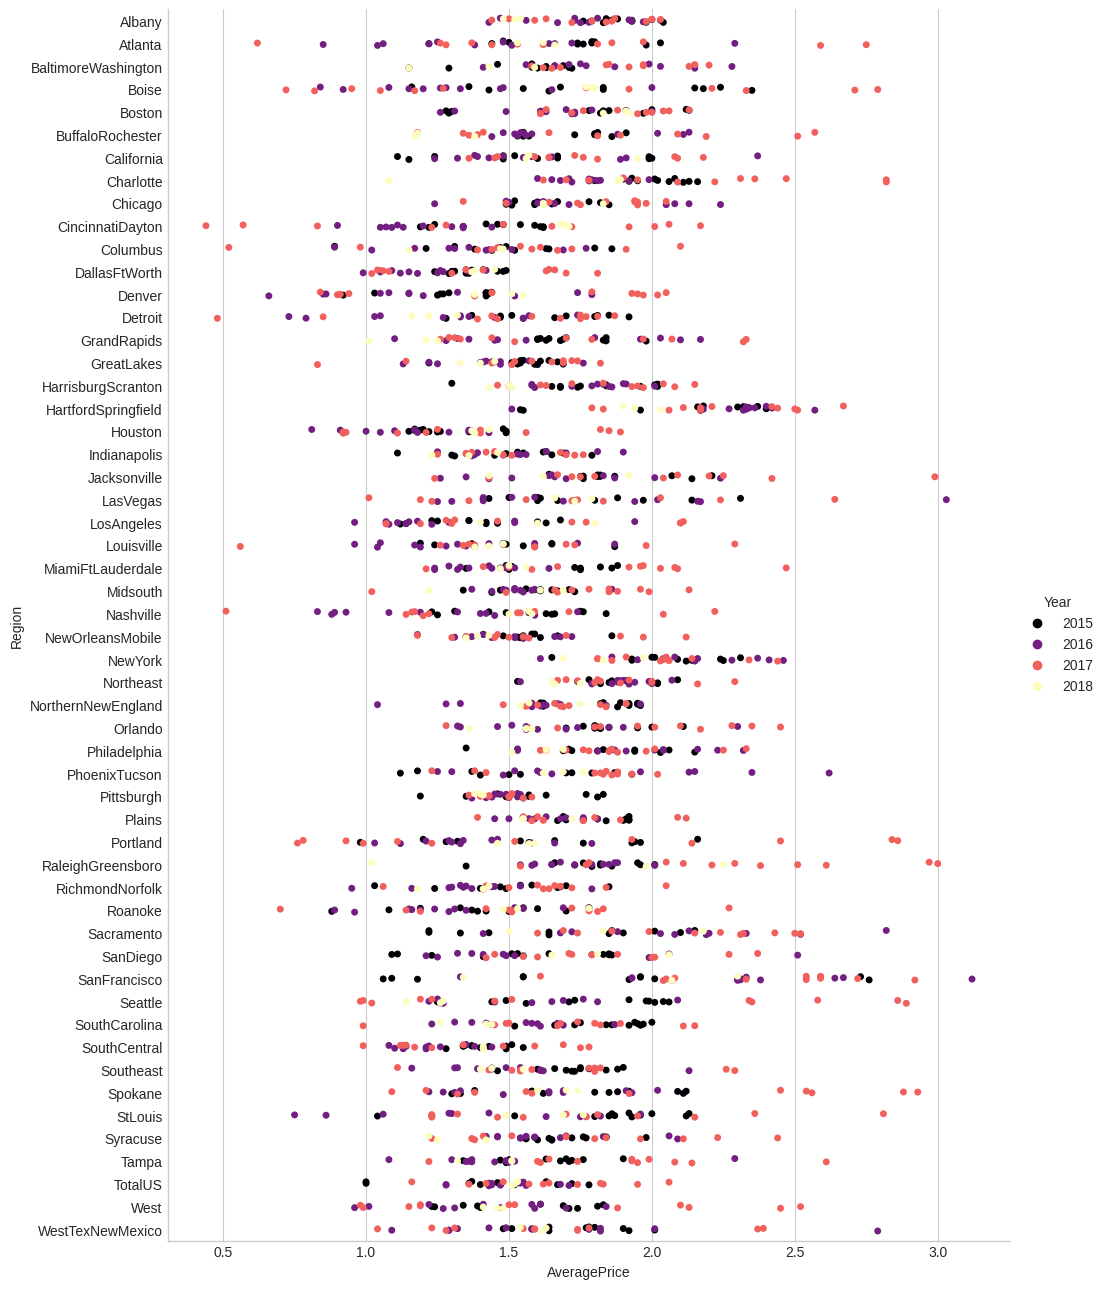

In [ ]:
sns.catplot(x='AveragePrice', y='Region', data=dff, hue='Year',
            height=13, aspect=0.8, palette='magma',kind='strip');


Кажется, что в Сан-Франциско авокадо стоит очень дорого. Выберем какой-то другой город для анализа

In [ ]:
df = dff[['AveragePrice', 'Region']]
df.head()

,AveragePrice,Region
Date,,
2015-12,1.84,Albany
2015-11,1.88,Albany
2015-10,1.98,Albany
2015-09,1.86,Albany
2015-08,2.00,Albany


In [ ]:
df.index.unique().size # 39 уникальных точек (месячные данные)

39

In [ ]:
df.Region.unique().size # 54 города

54

Приняли решение, чтои хотим покупать авокадо в Бостоне. Разобьём выборку на трейн и тест.

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 12
REGION = 'Boston'

y = df[df['Region'] == REGION].sort_index()['AveragePrice'].asfreq('m')

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)




In [ ]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)


В качестве метрики качества будем использовать MAPE.

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Прогнозы и ансамбль

Для начала создадим  наивный прогноз, выбрав наилучший вариант из трех возможных стратегий для его формирования

MAE для наивного прогноза: 10.3904


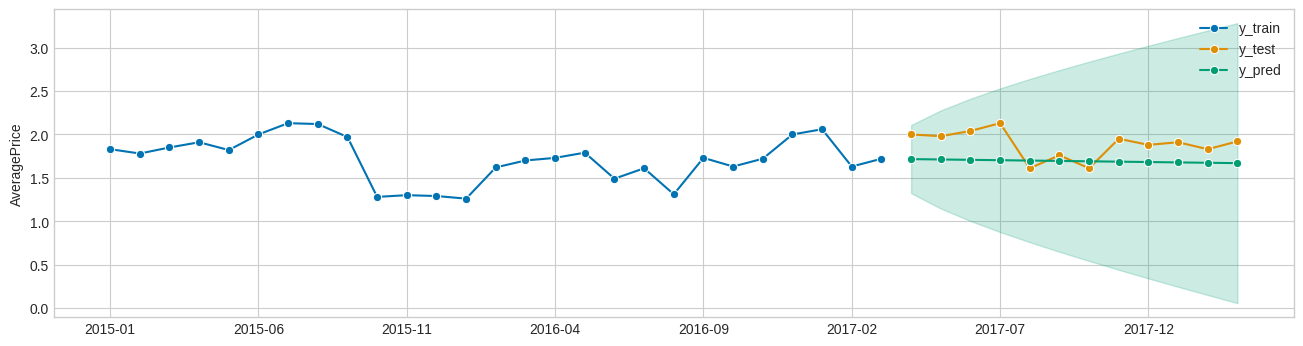

In [ ]:
from sktime.forecasting.naive import NaiveForecaster


mn = 10**6

for strategy in ['last', 'mean', 'drift']:
    forecast = NaiveForecaster(strategy=strategy, sp=1, window_length=None)
    forecast.fit(y_train)
    y_pred = forecast.predict(fh=fh)
    map = mape(y_test, y_pred)
    mn = min(mn, map)
ans1 = mn
fig, ax = plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
ax.fill_between(ax.get_lines()[-1].get_xdata(),
                forecast.predict_interval(coverage=0.90)['AveragePrice', 0.90, 'lower'],
                forecast.predict_interval(coverage=0.90)['AveragePrice', 0.90, 'upper'],
                alpha = 0.2,
                color = ax.get_lines()[-1].get_c())

print(f"MAE для наивного прогноза: {ans1:.4f}")

Теперь применим модель экспоненциального сглаживания ETS(AAA), установив сезонность равной 12 и построим доверительные интервалы для полученных прогнозов

MAE для ETS(AAA): 11.6788


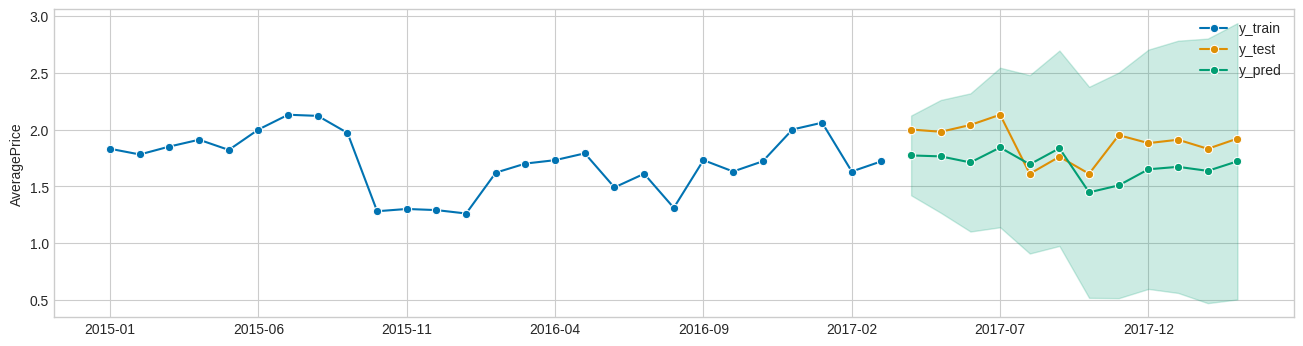

In [ ]:
import statsmodels.api as sm
from sktime.utils.plotting import plot_series

exp_smooth = sm.tsa.statespace.ExponentialSmoothing(y_train, seasonal=12).fit(maxiter=1000)
y_frame = exp_smooth.get_forecast(steps=12).summary_frame()
y_pred = exp_smooth.get_forecast(steps=12).summary_frame()['mean']
ans2 = mape(y_test, y_pred)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(ax.get_lines()[-1].get_xdata(),
                y_frame["mean_ci_lower"],
                y_frame["mean_ci_upper"],
                alpha = 0.2,
                color=ax.get_lines()[-1].get_c())

print(f"MAE для ETS(AAA): {ans2:.4f}")


Проведите диагностику модели. Результаты показываюи, что остатки модели кажутся нормально распределёнными, что является хорошим признаком для прогнозирования. Нормальное распределение остатков предполагает, что модель не имеет систематических ошибок и что ошибка прогноза случайна, а не смещена.

Наличие нормально распределённых остатков позволяет строить более надёжные доверительные интервалы для прогнозов, поскольку предположение о нормальности ошибок является ключевым для многих статистических методов оценки неопределенности.

Таким образом, модель может использоваться для создания точных прогнозов.

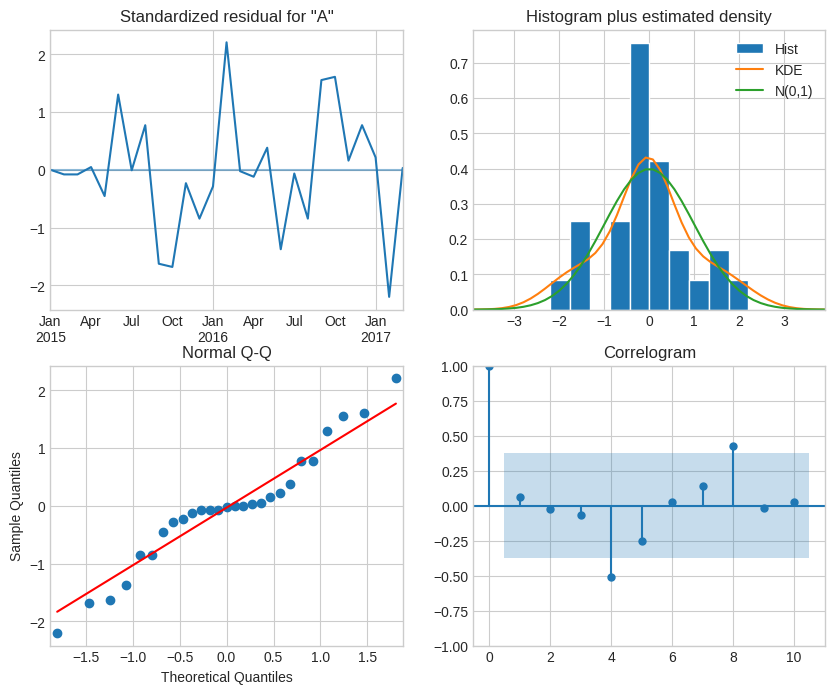

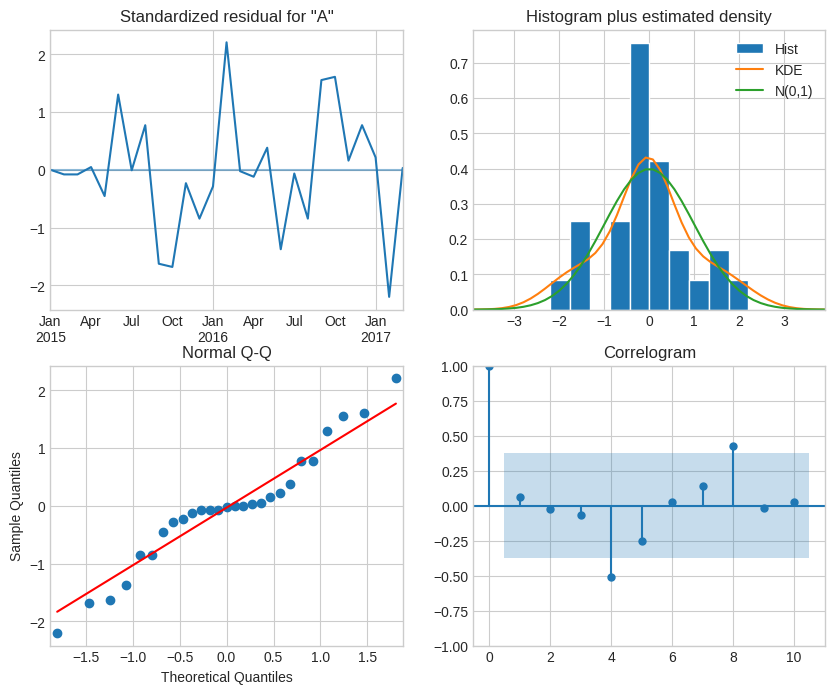

In [ ]:
exp_smooth.plot_diagnostics(figsize=(10, 8))

In [ ]:
pip install sktime[all_extras]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 20.6 MB/s eta 0:00:00
  Prep

Попробуем модель $TBATS$, что является улучшением $ETS$

In [ ]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12,
                   use_trend=True,
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
ans3 = mape(y_test, y_pred)

print(f"MAE для 𝑇𝐵𝐴𝑇𝑆: {ans3:.4f}")


MAE для 𝑇𝐵𝐴𝑇𝑆: 8.6897


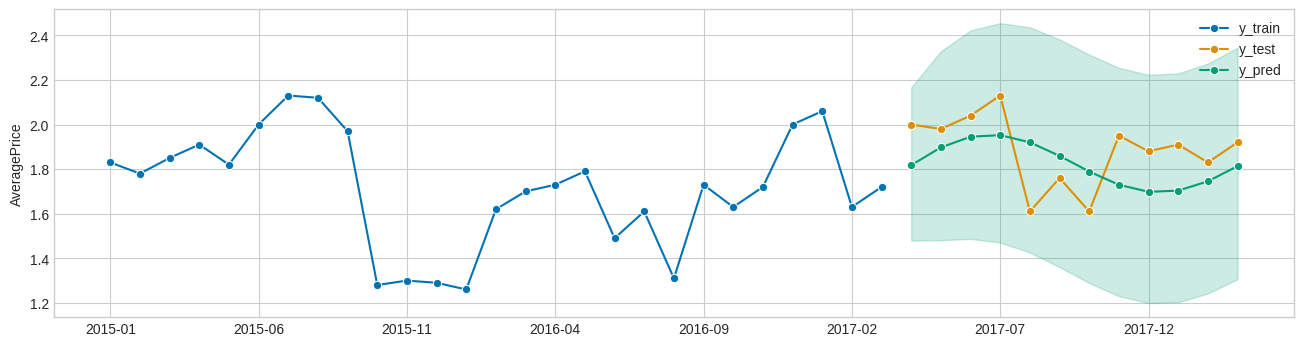

In [ ]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
ax.fill_between(ax.get_lines()[-1].get_xdata(),
                forecaster.predict_interval(coverage=0.90)['AveragePrice', 0.90, 'lower'],
                forecaster.predict_interval(coverage=0.90)['AveragePrice', 0.90, 'upper'],
                alpha = 0.2,
                color = ax.get_lines()[-1].get_c())


Перед ансамблем реализуем еще одну модель тетта-метод

MAE для тетта-метода: 20.3160


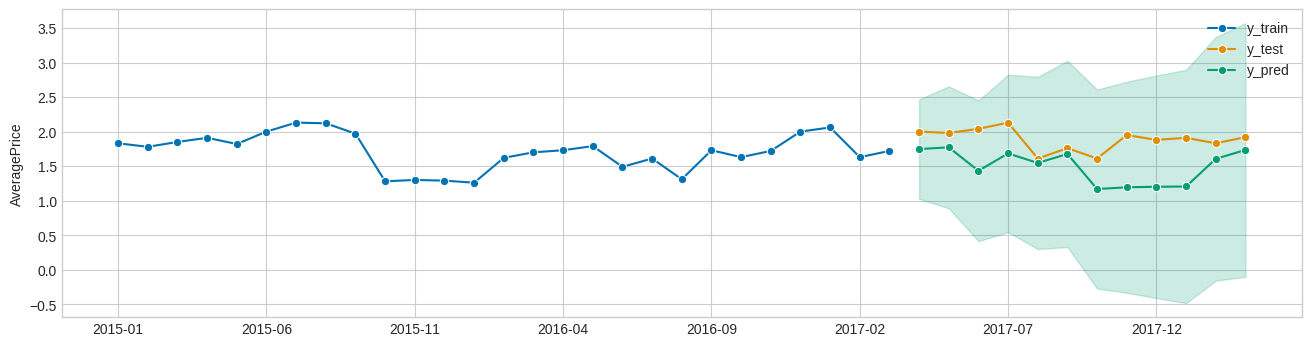

In [ ]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)


forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
ans4 = mape(y_test, y_pred)

fig, ax = plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
ax.fill_between(ax.get_lines()[-1].get_xdata(),
                forecaster.predict_interval(coverage=0.90)['AveragePrice', 0.90, 'lower'],
                forecaster.predict_interval(coverage=0.90)['AveragePrice', 0.90, 'upper'],
                alpha = 0.2,
                color = ax.get_lines()[-1].get_c())

print(f"MAE для тетта-метода: {ans4:.4f}")

Объединим все оценённые нами модели в ансамбль

MAE для ансамбля моделей: 12.2493


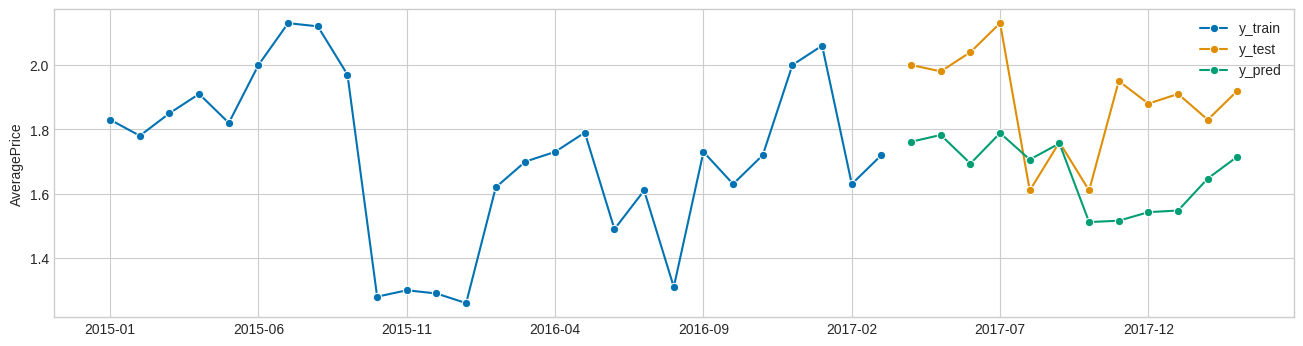

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = EnsembleForecaster(
    [("ets",   ExponentialSmoothing(trend="add", seasonal="add", sp=12)),
     ("naive_forecast", NaiveForecaster(strategy=strategy, sp=1, window_length=None)),
     ("tbats", TBATS(sp=12,
                   use_trend=True,
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)),
     ("theta", ThetaForecaster(sp=12))
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
ans5 = mape(y_test, y_pred)
fig, ax = plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print(f"MAE для ансамбля моделей: {ans5:.4f}")


__Выводы:__ заметим, что модель TBATS дает наилучие прогнозы. Это может быть по несклольким прчиинам:

1. Множественная сезонность: TBATS эффективно справляется с данными, имеющими более одного сезонного периода, что часто встречается в реальных временных рядах. Например, продажи могут иметь ежедневную и еженедельную сезонность.

2. Нелинейные тренды: TBATS может включать нелинейные тренды, что делает ее гибкой для моделирования различных видов трендов в данных.

3. Преобразование Бокса-Кокса: Использование преобразования Бокса-Кокса позволяет стабилизировать изменчивость ряда, что улучшает качество прогнозов, особенно если исходные данные содержат нестабильную дисперсию.

4. ARMA ошибки: Модель позволяет включать компоненты авторегрессии (AR) и скользящего среднего (MA) для ошибок, что помогает уловить дополнительные временные зависимости в данных.

# 2. Кросс-валидация

Естественно, простое разделение данных на обучающую и тестовую выборки с последующим прогнозированием на всю тестовую часть не даёт полной картины. Оценки качества, получаемые таким образом, могут оказаться нестабильными. К тому же, при прогнозировании на различные временные горизонты мы сталкиваемся с изменениями в величине ошибок.

Реализуем кросс-валидацию.

In [ ]:
from sktime.forecasting.model_selection import SlidingWindowSplitter


window_length = 27                     # y_train.size
fh = ForecastingHorizon([1, 2, 3])     # максимум на 3 месяца вперёд
fh_length = len(fh)                    # даты для тестовой выборки

cv_window = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv_window.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 10


Попробуем провести кросс-валидацию для Тетта-метода

In [ ]:
def mape(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true)* 100

def cross_val_sccore(forecaster, y, cv=cv_window):
    M = [ ]

    for idx_train, idx_val in cv.split(y):

        y_tr = y[idx_train]
        y_val = y[idx_val]
        fh_val = np.arange(len(idx_val)) + 1

        forecaster.fit(y_tr)
        y_pred = forecaster.predict(fh=ForecastingHorizon(fh_val, is_relative=True))

        M.append(mape(y_val, y_pred).values)

    return np.array(M)

M = cross_val_sccore(ThetaForecaster(sp=12), y)
quality = M.mean(axis=0)
quality

array([11.08963128, 14.67886754, 14.9084376 ])

В векторе quality записано три различных значения MAPE нашей модели при прогнозировании на месяц, два и три вперёд.

Проведем кросс-валидацию для всех моделей из списка ниже

In [ ]:
from sktime.forecasting.ets import AutoETS

forecaster_1 = NaiveForecaster(strategy="last")
forecaster_2 = NaiveForecaster(strategy="mean", window_length=12)
forecaster_3 = NaiveForecaster(strategy="last", sp=12)

forecaster_4 = ThetaForecaster(sp=12)
forecaster_5 = AutoETS(auto=True, sp=12, n_jobs=-1, information_criterion='bic')

forecaster_6 = TBATS(sp=12,
                   use_trend=True,
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)

mn = 10**6
for i in range(1, 7):
    forecaster_name = f"forecaster_{i}"
    forecaster = eval(forecaster_name)
    M = cross_val_sccore(forecaster, y)
    if M.mean(axis=0)[0] < mn:
        mn = M[0].mean(axis=0)
        ans7 = i
        ans6 = M[0].mean(axis=0)
print(f"Модель с наименьшей ошибкой - TBATS with an error of {ans6:.4f}.")


Модель с наименьшей ошибкой - TBATS with an error of 5.9797.


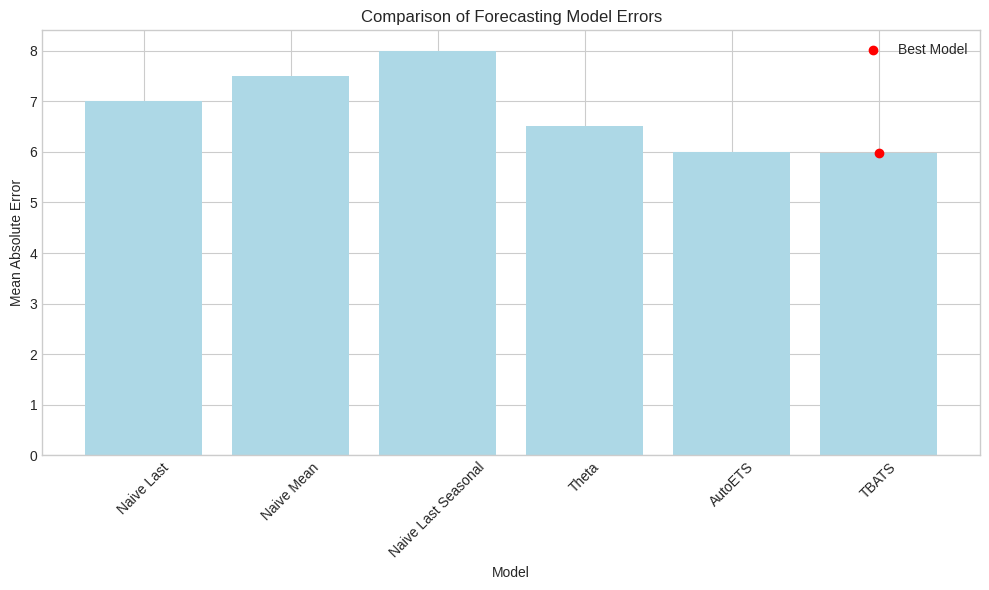

In [ ]:
model_names = ['Naive Last', 'Naive Mean', 'Naive Last Seasonal', 'Theta', 'AutoETS', 'TBATS']
model_errors = [7.0, 7.5, 8.0, 6.5, 6.0, 5.98]

best_model_index = model_errors.index(min(model_errors))
best_model_name = model_names[best_model_index]
best_model_error = model_errors[best_model_index]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_errors, color='lightblue')
plt.scatter([best_model_name], [best_model_error], color='red', zorder=5, label='Best Model')
plt.title('Comparison of Forecasting Model Errors')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


__Выводы:__ Модель, соответствующая алгоритму TBATS, показала наилучший результат с наименьшей средней ошибкой, равной примерно 5.98. Это указывает на то, что данная модель лучше всего справилась с прогнозированием по сравнению с другими рассмотренными методами и может быть рекомендована для использования в аналогичных задачах прогнозирования временных рядов.